In [1]:
import pandas as pd

In [3]:
df = pd.read_excel("Presidentielle_2017_Resultats_Communes_Tour_2_c.xls",header=3)
print(df.head(2))
print("----------------------------------------------")
print(df.info())

  Code du département Libellé du département  Code de la commune  \
0                   1                    Ain                   1   
1                   1                    Ain                   2   

     Libellé de la commune  Inscrits  Abstentions  % Abs/Ins  Votants  \
0  L'Abergement-Clémenciat       598          100      16.72      498   
1    L'Abergement-de-Varey       209           32      15.31      177   

   % Vot/Ins  Blancs     ...       Voix  % Voix/Ins  % Voix/Exp  N°Panneau.1  \
0      83.28      37     ...        272       45.48       60.04            2   
1      84.69      21     ...         93       44.50       62.00            2   

   Sexe.1   Nom.1  Prénom.1  Voix.1  % Voix/Ins.1 % Voix/Exp.1  
0       F  LE PEN    Marine     181         30.27        39.96  
1       F  LE PEN    Marine      57         27.27        38.00  

[2 rows x 32 columns]
----------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35719 entries, 0 to

In [100]:
df = df.rename(columns = {'Voix':'MACRON'})
df = df.rename(columns = {'Voix.1':'PEN'})
df["winner"] = df.eval("MACRON >= PEN").map({True:1,False:0})
df_cleaned = df[["Libellé de la commune","% Abs/Ins","% Blancs/Ins","% Nuls/Vot","winner"]]
df_cleaned.columns=["town","abstention/subscribers","whiteballot/subscribers","invalid/voters","winner"]
df_cleaned.head()
df_cleaned.to_pickle('df_clean')

In [5]:
print("Results of elections by number of towns")
print(df_cleaned.winner.value_counts().rename({0: "LE PEN", 1: "MACRON"}))
print("----------------------------------------------")
print("new dataset")
print(df_cleaned.head())


Results of elections by number of towns
MACRON    26530
LE PEN     9189
Name: winner, dtype: int64
----------------------------------------------
new dataset
                      town  abstention/subscribers  whiteballot/subscribers  \
0  L'Abergement-Clémenciat                   16.72                     6.19   
1    L'Abergement-de-Varey                   15.31                    10.05   
2        Ambérieu-en-Bugey                   26.93                     7.00   
3      Ambérieux-en-Dombes                   22.10                     6.57   
4                  Ambléon                   23.23                    17.17   

   invalid/voters  winner  
0            1.61       1  
1            3.39       1  
2            3.46       1  
3            2.63       1  
4            0.00       1  


In [79]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

nclusters = 20;
X = df_cleaned.iloc[:,1:4].as_matrix()
X_normalized = StandardScaler().fit(X).transform(X)  
labels = np.array(list(df_cleaned.town))
    
# applying the model
kmeans = KMeans(n_clusters = nclusters)
kmeans.fit(X)
pred_classes = kmeans.predict(X)
    
# allocating the cluster
df["cluster"] = pred_classes + 1

# Print different clusters
for cluster in range(nclusters):
    print('')
    print('cluster: ', cluster+1)
    print(labels[np.where(pred_classes == cluster)])

# get the label axis list
listAxis = list(df_cleaned.iloc[:,1:4].columns)


cluster:  1
["L'Abergement-Clémenciat" 'Beaupont' 'Boyeux-Saint-Jérôme' ...,
 'Wy-dit-Joli-Village' 'Maupiti' 'Rapa']

cluster:  2
['Belleydoux' 'Champagne-en-Valromey' 'Cormoz' ...,
 'Gironville-sur-Essonne' 'Roinvilliers' 'Neuilly-en-Vexin']

cluster:  3
['Suzan' 'Guagno' 'Moca-Croce' 'Rosazia' 'Zicavo' 'Carcheto-Brustico'
 'Casabianca' 'Casalta' 'Casamaccioli' 'Corscia' 'Loreto-di-Casinca'
 'Mausoléo' 'Mazzola' "Monacia-d'Orezza" 'Muro' 'Olmo' 'Pietroso' 'Rusio'
 'Sorio' 'San-Lorenzo' 'Santa-Lucia-di-Mercurio' 'Tox' 'Tralonca' 'Vignale'
 'Vivario' 'Les Abymes' 'Baillif' 'Basse-Terre' 'Bouillante'
 'Capesterre-Belle-Eau' 'Capesterre-de-Marie-Galante' 'Gourbeyre'
 'La Désirade' 'Deshaies' 'Grand-Bourg' 'Le Gosier' 'Goyave' 'Lamentin'
 "Morne-à-l'Eau" 'Le Moule' 'Petit-Bourg' 'Petit-Canal' 'Pointe-à-Pitre'
 'Pointe-Noire' 'Port-Louis' 'Sainte-Anne' 'Sainte-Rose' 'Terre-de-Bas'
 'Terre-de-Haut' 'Vieux-Fort' 'Vieux-Habitants' "L'Ajoupa-Bouillon"
 "Les Anses-d'Arlet" 'Basse-Pointe' 'Le D


----> 2D plot kmeans clusters



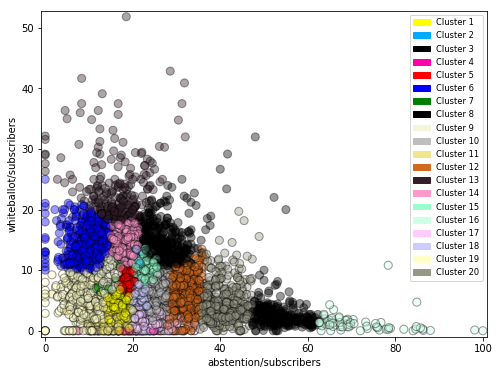


----> 2D plot kmeans clusters



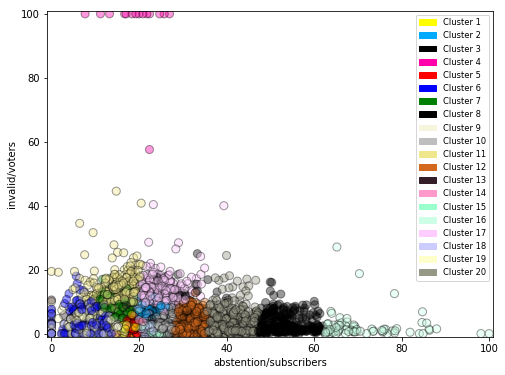


----> 2D plot kmeans clusters



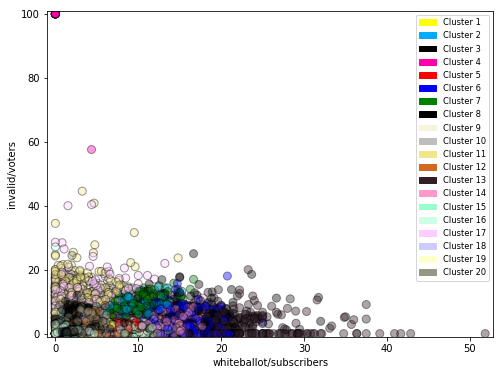

In [84]:
plot_user_scatter(X, kmeans.labels_, ['Cluster {}'.format(i+1) for i in range(nclusters) ], 0,  1, listAxis)
plot_user_scatter(X, kmeans.labels_, ['Cluster {}'.format(i+1) for i in range(nclusters) ], 0,  2, listAxis)
plot_user_scatter(X, kmeans.labels_, ['Cluster {}'.format(i+1) for i in range(nclusters) ], 1,  2, listAxis)

In [83]:
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from matplotlib import colors as mcolors
from matplotlib.font_manager import FontProperties

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

import matplotlib._color_data as mcd
def plot_user_scatter(X, y, class_labels, i, j, listAxis):
    print('')
    print('----> 2D plot kmeans clusters')
    print('')
    num_labels = len(class_labels)

    x_min, x_max = X[:, i].min() - 1, X[:, i].max() + 1
    y_min, y_max = X[:, j].min() - 1, X[:, j].max() + 1

    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA','R','B','G','K',
                  '#F5F5DC','#BEBEBE','#F0E68C','#D2691E','#331E28','#FF99CC','#99FFCC',
            '#CCFFE6','#FFCCFF','#CCCCFF','#FFFFCC','#979785','#488997','#EDEEE3',
            '#5CB0C2','#5199A8','#07A3B2','#BA3951','#4B0D2B','#E9B704','#8E3843',
            '#134913','#C50D63','#CD7EA0','#596B53','#9A616E','#82486B','#95818C',
            '#07A3B2','#C50D63','#E47446','#055F65','#CBAA5C','#076E4E']
    
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure(figsize=(8, 6))

    plt.scatter(X[:, i], X[:, j], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)
    plt.xlabel('{}'.format(listAxis[i]))
    plt.ylabel('{}'.format(listAxis[j]))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    fontP = FontProperties()
    fontP.set_size('small')
    plt.legend(handles=h,prop=fontP)

    plt.show()

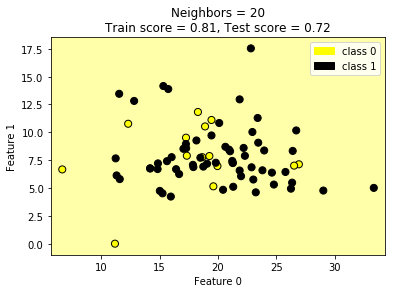

In [92]:
from sklearn.model_selection import train_test_split
X = df_cleaned.iloc[:,1:3].as_matrix()
y = df_cleaned.iloc[:,4].as_matrix()
# Only for small visualization
k = 100
indices = np.random.randint(0,X.shape[0],k)
X = X[indices]
y = y[indices]
# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
plot_two_class_knn(X_train, y_train, 20, 'uniform', X_test, y_test)

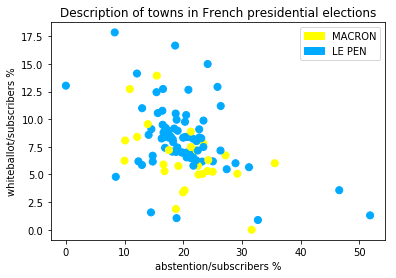

In [89]:
# synthetic dataset for classification (binary) 
plt.figure()
plt.title('Description of towns in French presidential elections')
cmap_bold = ListedColormap(['#FFFF00', '#FF00AA', '#000000', '#00AAFF'])
color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA','r','b','g','k']
plt.scatter(X[:, 0], X[:, 1], c=y,
           marker= 'o', s=50, cmap=cmap_bold)
plt.xlabel('abstention/subscribers %')
plt.ylabel('whiteballot/subscribers %')
h = []
for c in range(0, 2):
    h.append(mpatches.Patch(color=color_array[c], label=["MACRON","LE PEN"][c]))
plt.legend(handles=h)
plt.show()

In [90]:
from sklearn import neighbors
import numpy
def plot_two_class_knn(X, y, n_neighbors, weights, X_test, y_test):
    X_mat = X
    y_mat = y

    # Create color maps
    cmap_light = ListedColormap(['#FFFFAA', '#AAFFAA', '#AAAAFF','#EFEFEF'])
    cmap_bold  = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.
    
    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50
    
    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, mesh_step_size),
                         numpy.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    title = "Neighbors = {}".format(n_neighbors)
    if (X_test is not None):
        train_score = clf.score(X_mat, y_mat)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    patch0 = mpatches.Patch(color='#FFFF00', label='LE PEN')
    patch1 = mpatches.Patch(color='#000000', label='MACRON')
    plt.legend(handles=[patch0, patch1])

    plt.xlabel('Feature 0')
    plt.ylabel('Feature 1')
    plt.title(title)

    plt.show()

In [98]:
# loading library
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)
# dataset
X = df_cleaned.iloc[:,1:3].as_matrix()
y = df_cleaned.iloc[:,4].as_matrix()

# from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

# fitting the model
knn.fit(X_train, y_train)

# predict the response
pred = knn.predict(X_test)

# predict the response
preTrain = knn.predict(X_train)

# evaluate accuracy
print("Accuracy of train set : ",accuracy_score(y_train, preTrain))
print("Accuracy of test set : ",accuracy_score(y_test, pred))

Accuracy of train set :  0.809175407817
Accuracy of test set :  0.669652855543
